# k近邻

### 杜小勤，武汉纺织大学数学与计算机学院，2020年02月06日
https://github.com/duxiaoqin/Lecture-notes-for-Machine-Learning

相似性度量——$L_{p}$距离（$L_{p}$ Distance）或Minkowski距离（Minkowski Distance）:
- p = 1 曼哈顿距离
- p = 2 欧氏距离
- p = $\infty$ 闵氏距离

In [1]:
import math

In [2]:
def distance(a, b, p = 2):
    if p == float('inf'):
        maxi = float('-inf')
        for i in range(len(a)):
            maxi = max(maxi, abs(a[i] - b[i]))
        return maxi
    else:
        sum = 0
        for i in range(len(a)):
            sum += math.pow(abs(a[i] - b[i]), p)
        return math.pow(sum, 1/p)

In [3]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]
print(distance(x1, x2, p = 1))
print(distance(x1, x2, p = 2))
print(distance(x1, x2, p = 3))
print(distance(x1, x2, p = 4))
print(distance(x1, x2, p = float('inf')))
print()
print(distance(x1, x3, p = 1))
print(distance(x1, x3, p = 2))
print(distance(x1, x3, p = 3))
print(distance(x1, x3, p = 4))
print(distance(x1, x3, p = float('inf')))

4.0
4.0
3.9999999999999996
4.0
4

6.0
4.242640687119285
3.7797631496846193
3.5676213450081633
3


使用numpy.linalg.norm函数计算范数

In [4]:
import numpy as np

In [5]:
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 1))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 2))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 3))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 4))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = float('inf')))
print()
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 1))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 2))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 3))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 4))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = float('inf')))

4.0
4.0
4.0
4.0
4.0

6.0
4.24264068712
3.77976314968
3.56762134501
3.0


载入鸢尾花数据集

In [6]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

np.random.seed()

In [7]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['label'] = iris.target

data = np.array(iris_df.iloc[:100, [0, 1, -1]]) #取出第0列、第1列、最后一列，前100条记录
X, Y = data[:, :-1], data[:, -1]
print(data.shape)

(100, 3)


绘制训练数据集

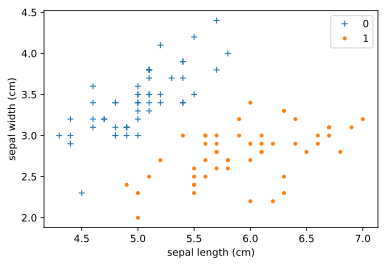

In [8]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('KNN_OUTPUT1.pdf', bbox_inches='tight')

保存数据集，以后可以直接使用

In [9]:
np.savez_compressed('iris.npz', data = data, X = X, Y = Y)

测试刚才保存的训练数据集

In [10]:
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

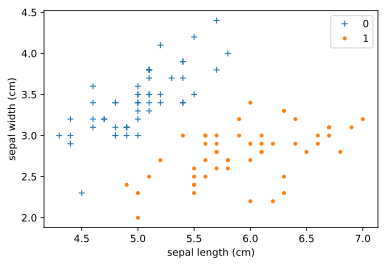

In [11]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('KNN_OUTPUT2.pdf', bbox_inches='tight')

kd树的生成

In [12]:
class KDNode:
    def __init__(self, sample, feature_index, left, right):
        self.sample = sample
        self.feature_index = feature_index
        self.left = left
        self.right = right

In [13]:
class KDTree:
    def __init__(self, dataset):
        self.n_features = dataset.shape[1] - 1 #最后一列是标签
        self.root = self.Build(dataset, 0)
        
    def Build(self, dataset, feature_index):
        if len(dataset) == 0:
            return None
        dataset = sorted(dataset, key = lambda x: x[feature_index])
        split_pos = len(dataset) // 2
        return KDNode(dataset[split_pos], feature_index,\
                     self.Build(dataset[:split_pos], (feature_index + 1) % self.n_features),\
                     self.Build(dataset[split_pos+1:], (feature_index + 1) % self.n_features))
    
    #参数：KDTree树节点KDNode、源数据点、KDTree中的最近数据点、最近距离
    #返回：KDTree中的最近数据点、最近距离
    def _FindNearest(self, kdnode, source, target, mindist):
        if kdnode == None: #无节点可以访问
            return None, float('inf') #分别表示数据点、距离
        
        #当前节点
        pivot = kdnode.sample
        if source[kdnode.feature_index] <= pivot[kdnode.feature_index]: #左子树
            forward = kdnode.left
            backward = kdnode.right
        else: #右子树
            forward = kdnode.right
            backward = kdnode.left
        
        #往子树递归访问
        forward_result = self._FindNearest(forward, source, target, mindist)
        if forward_result[1] < mindist: #发现目前最近距离
            target = forward_result[0]
            mindist = forward_result[1]
            
        to_pivot = np.linalg.norm(source[:-1] - pivot[:-1], ord = 2) #-1，去除标签数据
        if mindist < to_pivot: #pivot离source更远，不可能找到更近的点，不访问另一分支backward，直接返回
            return target, mindist

        #发现更近的数据点，更新数据
        target = pivot
        mindist = to_pivot

        #继续在另一分支backward上搜索，有可能找到更近的点
        backward_result = self._FindNearest(backward, source, target, mindist)
        if backward_result[1] < mindist: #发现目前最近距离
            target = backward_result[0]
            mindist = backward_result[1]
            
        return target, mindist
    
    def Nearest(self, source):
        result = self._FindNearest(self.root, source, None, float('inf'))
        return result[0] #返回KDTree中的最近数据点
        

测试《统计学习方法》第2版，李航，P55实例

生成KDTree

In [14]:
#最后一列是标签
example_data = np.array([[2, 3, 0],[5, 4, 0],[9, 6, 0],[4, 7, 1],[8, 1, 1],[7, 2, 1]])
example_kdtree = KDTree(example_data)

按先根遍历打印KDTree

In [15]:
def print_kdtree(root):
    if root == None:
        return
    print(root.sample)
    print_kdtree(root.left)
    print_kdtree(root.right)
print_kdtree(example_kdtree.root)

[7 2 1]
[5 4 0]
[2 3 0]
[4 7 1]
[9 6 0]
[8 1 1]


在KDTree树中搜索

In [16]:
source = np.array([2, 16, 0])
print('Nearst:', example_kdtree.Nearest(source))

Nearst: [4 7 1]


按穷举法搜索

In [17]:
print('Nearst:', example_data[np.argmin([np.linalg.norm(item[:-1]-source[:-1], ord = 2) for item in example_data])])

Nearst: [4 7 1]


测试随机生成的数据

In [18]:
from time import clock
from random import random

K = 6 #维度5，最后1维，假定为标签
N = 400000
random_data = np.array([[random() for k in range(K)] for n in range(N)])
t0 = clock()
random_kdtree = KDTree(random_data)
t1 = clock()
print ("KDTree building time: ", t1-t0, "s")
source = [random() for k in range(K)]
t0 = clock()
print('Nearst:', random_kdtree.Nearest(source)) #在KDTree树中搜索
t1 = clock()
print ("KDTree searching time: ", t1-t0, "s")
t0 = clock()
print('Nearst:', random_data[np.argmin([np.linalg.norm(item[:-1]-source[:-1], ord = 2) for item in random_data])]) #按穷举法搜索
t1 = clock()
print ("One-by-one searching time: ", t1-t0, "s")

KDTree building time:  6.3251292875099425 s
Nearst: [ 0.90124998  0.71193777  0.87953213  0.89937157  0.18528211  0.35873041]
KDTree searching time:  0.0014760656600749655 s
Nearst: [ 0.90124998  0.71193777  0.87953213  0.89937157  0.18528211  0.35873041]
One-by-one searching time:  2.867321243509271 s


测试鸢尾花数据集

In [19]:
iris_kdtree = KDTree(data)
source = np.array([5, 4, 0])
print('Nearst:', iris_kdtree.Nearest(source)) #在KDTree树中搜索
print('Nearst:', data[np.argmin([np.linalg.norm(item[:-1]-source[:-1], ord = 2) for item in data])]) #按穷举法搜索

Nearst: [ 5.1  3.8  0. ]
Nearst: [ 5.1  3.8  0. ]


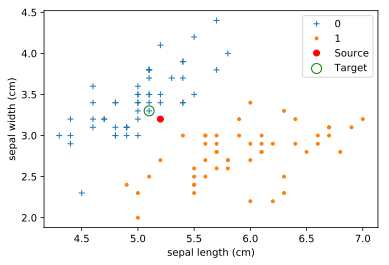

In [20]:
source = np.array([5.2, 3.2, 0])
target = iris_kdtree.Nearest(source)
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.plot(source[0], source[1], 'ro', label='Source')
plt.scatter(target[0], target[1], color = '', marker = 'o', edgecolors = 'g', s = 100, label='Target')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('KNN_OUTPUT3.pdf', bbox_inches='tight')

sklearn的kNN分类器

sklearn.neighbors.KNeighborsClassifier
- n_neighbors: 临近点个数
- p: 距离度量
- algorithm: 实现算法，可选{'auto', 'ball_tree', 'kd_tree', 'brute'}
- weights: 确定近邻的权重

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

鸢尾花数据集的80%用作训练数据，20%用作测试数据

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [23]:
clf = KNeighborsClassifier()
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
clf.score(X_test, Y_test)

1.0

参考文献：
- https://github.com/wzyonggege/statistical-learning-method;
- 《统计学习方法》第2版，李航；